Epoch 1, Train Loss: 0.439039, Train Acc: 0.832383, Test Loss: 0.486719, Test Acc: 0.815900
Epoch 2, Train Loss: 0.400495, Train Acc: 0.848017, Test Loss: 0.448177, Test Acc: 0.831800
Epoch 3, Train Loss: 0.326678, Train Acc: 0.878733, Test Loss: 0.383920, Test Acc: 0.858700
Epoch 4, Train Loss: 0.313062, Train Acc: 0.884567, Test Loss: 0.375746, Test Acc: 0.862600
Epoch 5, Train Loss: 0.308385, Train Acc: 0.886867, Test Loss: 0.384102, Test Acc: 0.859900
Epoch 6, Train Loss: 0.265247, Train Acc: 0.900683, Test Loss: 0.343396, Test Acc: 0.876800
Epoch 7, Train Loss: 0.263040, Train Acc: 0.901283, Test Loss: 0.344171, Test Acc: 0.874200
Epoch 8, Train Loss: 0.280382, Train Acc: 0.892583, Test Loss: 0.369302, Test Acc: 0.868400
Epoch 9, Train Loss: 0.244775, Train Acc: 0.908233, Test Loss: 0.349445, Test Acc: 0.879200
Epoch 10, Train Loss: 0.238979, Train Acc: 0.911433, Test Loss: 0.350383, Test Acc: 0.881500


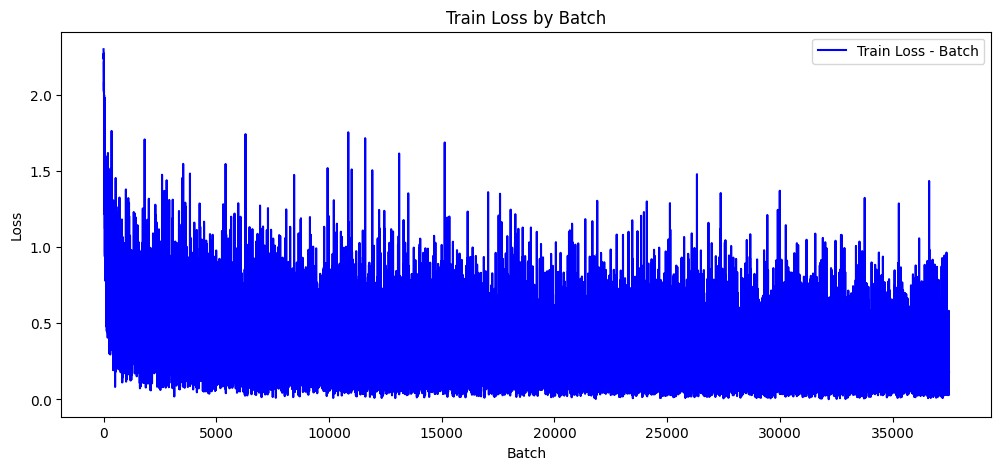

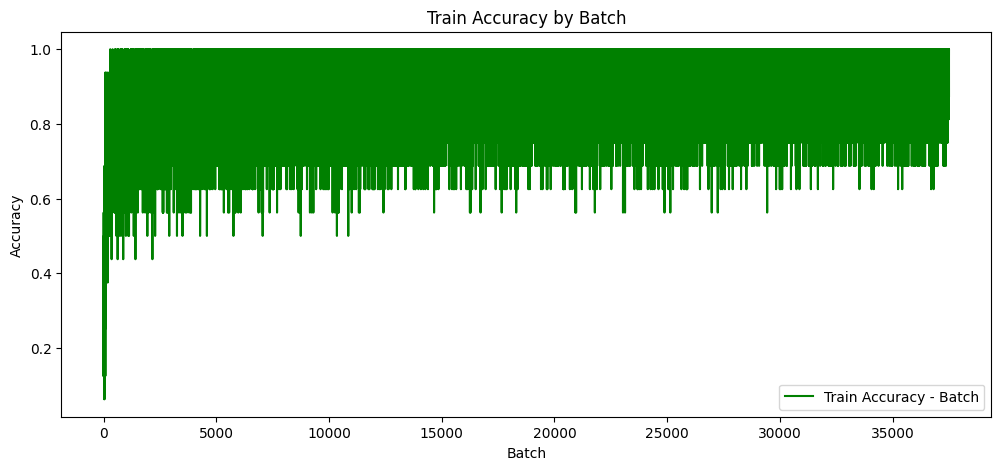

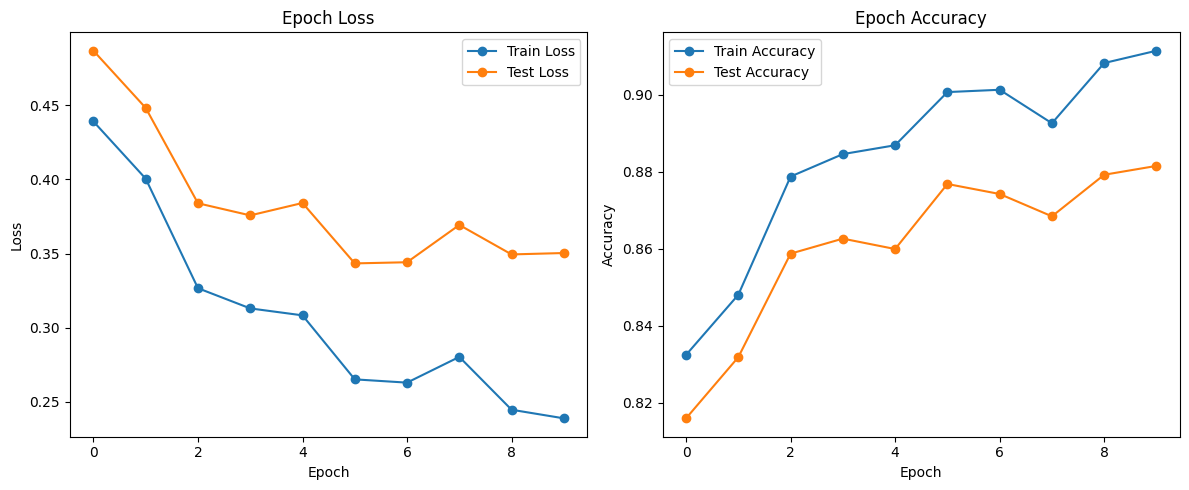

In [2]:
import torch
from torch.autograd import Variable
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import config

args = config.args
device = torch.device('cuda' if not args.cpu and torch.cuda.is_available() else 'cpu')

# Data loading
trans = transforms.ToTensor()
mnist_train = datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)

# Model definition
class CustomNetwork(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super(CustomNetwork, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)
        # Initialize parameters
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model instantiation, loss, and optimizer
model = CustomNetwork(784, 256, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr)

# Data loading
train_loader = DataLoader(mnist_train, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=10000, shuffle=False)

# Function to evaluate the network
def accuracy(loader):
    total_loss, total_correct, total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 784).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
            total += labels.size(0)
    model.train()
    return total_loss / len(loader), total_correct / total

# Metrics storage
batch_metrics = {
    'train_losses': [], 
    'train_accs': [], 
    'test_losses': [], 
    'test_accs': []
}
epoch_metrics = {
    'train_losses': [], 
    'train_accs': [], 
    'test_losses': [], 
    'test_accs': []
}

# Training and evaluation loop
for epoch in range(args.epochs):
    for images, labels in train_loader:
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record batch loss and accuracy
        batch_loss = loss.item()
        batch_accuracy = (output.argmax(1) == labels).float().mean().item()
        batch_metrics['train_losses'].append(batch_loss)
        batch_metrics['train_accs'].append(batch_accuracy)

    # Evaluate on test data after each epoch
    test_loss, test_accuracy = accuracy(test_loader)
    batch_metrics['test_losses'].append(test_loss)
    batch_metrics['test_accs'].append(test_accuracy)
    
    # Record epoch metrics
    epoch_train_loss, epoch_train_acc = accuracy(train_loader)
    epoch_metrics['train_losses'].append(epoch_train_loss)
    epoch_metrics['train_accs'].append(epoch_train_acc)
    epoch_metrics['test_losses'].append(test_loss)
    epoch_metrics['test_accs'].append(test_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.6f}, Train Acc: {epoch_train_acc:.6f}, Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.6f}')

# Plotting code

# Plotting
# 绘制训练损失的曲线图
plt.figure(figsize=(12, 5))
plt.plot(batch_metrics['train_losses'], label='Train Loss - Batch', color='blue')
plt.title('Train Loss by Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 绘制训练准确率的曲线图
plt.figure(figsize=(12, 5))
plt.plot(batch_metrics['train_accs'], label='Train Accuracy - Batch', color='green')
plt.title('Train Accuracy by Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# 绘制训练和测试损失的曲线图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_metrics['train_losses'], label='Train Loss', marker='o')
plt.plot(epoch_metrics['test_losses'], label='Test Loss', marker='o')
plt.title('Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和测试准确率的曲线图
plt.subplot(1, 2, 2)
plt.plot(epoch_metrics['train_accs'], label='Train Accuracy', marker='o')
plt.plot(epoch_metrics['test_accs'], label='Test Accuracy', marker='o')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


torch.save(model.state_dict(), 'fashion_mnist.pt')